In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import yfinance as yf
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import json
import random
import cvxpy
# from cvxpy import *
import gym
from gym.utils import seeding
from gym import spaces
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, SimpleRNN, Dense, Dropout
from dateutil.relativedelta import relativedelta

In [ ]:
import sys

# Neural Nets

In [ ]:
class PortfolioModelTrainer:
    def __init__(self, model_type, asset_num, input_shape, param_grid, timestamp, wts=None):
        self.model_type = model_type
        self.model = None
        self.asset_num = asset_num
        self.input_shape = input_shape
        self.param_grid = param_grid
        self.best_params = None
        self.best_score = np.inf
        self.wts = wts
        self.timestamp = timestamp

    # custom loss function for gradient ascent Sharpe Ratio
    def negative_sharpe_loss(self, rets, wts):

        mean_return = tf.reduce_mean(tf.reduce_sum(wts * rets, axis=1))
        std_return = tf.math.reduce_std(tf.reduce_sum(wts * rets, axis=1))
        if std_return != 0.0:
          return -mean_return / std_return
        else:
          return 0.0

    def build_model(self, params):
        self.model = Sequential()

        if self.model_type == "CNN":

          self.model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation=params['activation'], input_shape=self.input_shape))
          self.model.add(MaxPooling1D(pool_size=2))
          self.model.add(Flatten())
          self.model.add(Dropout(params['dropout_rate']))
          self.model.add(Dense(params['dense_units'], activation=params['activation']))

        elif self.model_type == "RNN":
           self.model.add(SimpleRNN(params['input_layer_size'], input_shape=self.input_shape))
           self.model.add(Dropout(params['dropout_rate']))

        elif self.model_type == "MLP":

          for i in range(params['num_hidden_layers']):
            if i==0:
              self.model.add(Dense(units=params['hidden_layer_sizes'], activation=params['activation'], input_shape=self.input_shape))
            else:
              self.model.add(Dense(units=params['hidden_layer_sizes'], activation=params['activation']))

            if params['dropout_rate'] > 0.0:
              self.model.add(Dropout(params['dropout_rate']))

        else:
           raise ValueError("Invalid model type. Supported types: 'CNN', 'RNN', 'MLP'")

        self.model.add(Dense(units=self.asset_num, activation="softmax")) # <- softmax creates long-only portfolios

        optimizer_instance = tf.keras.optimizers.get(params['optimizer'])
        optimizer_instance.learning_rate = params['learning_rate']

        self.model.compile(optimizer=optimizer_instance, loss=self.negative_sharpe_loss)

    def walk_forward_train(self, n_train, n_val, df, batch, params, idx):
        n_splits = (df.shape[0] - n_train) // n_val + 1
        avg_score = 0.0

        preds = []

        if not os.path.exists(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/preds/{timestamp}/{self.model_type}/"):
            os.makedirs(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/preds/{timestamp}/{self.model_type}/")

        with open(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/preds/{timestamp}/{self.model_type}/param_mapping.txt", "a") as f:
            if idx == 0:
              f.write(self.model_type)
              f.write('\n')
            f.write(f'{idx}: {str(params)}\n')

        for i in range(0, df.shape[0] - n_train, n_val):

            if params['window_type'] == 'fix':

                X_train, y_train = df.iloc[i : i + n_train, :-self.asset_num], df.iloc[i : i + n_train, -self.asset_num:]
                X_val, y_val = df.iloc[i + n_train : i + n_train + n_val, :-self.asset_num], df.iloc[i + n_train : i + n_train + n_val, -self.asset_num:]

            elif params['window_type'] == 'exp':
                X_train, y_train = df.iloc[: i + n_train, :-self.asset_num], df.iloc[: i + n_train, -self.asset_num:]
                X_val, y_val = df.iloc[i + n_train : i + n_train + n_val, :-self.asset_num], df.iloc[i + n_train : i + n_train + n_val, -self.asset_num:]

            # Define EarlyStopping callback
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            history = self.model.fit(
                X_train,
                y_train,
                epochs=params['epochs'],
                batch_size=batch,
                validation_data = (X_val, y_val),
                callbacks=[early_stopping],
                verbose=1
            )

            y_pred = self.model.predict(X_val, verbose=0)
            preds.append(y_pred)
            pd.DataFrame(y_pred).to_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/preds/{timestamp}/{self.model_type}/y_pred_{i}_params{idx}.csv")

            y_val.to_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/preds/{timestamp}/{self.model_type}/y_val_{i}_params{idx}.csv")

            score = self.model.evaluate(X_val, y_val, verbose=0)

            avg_score += score / n_splits

        return preds, avg_score

    def grid_search(self, n_train, n_val, df, batch):
       total_combos = len(ParameterGrid(self.param_grid))

       for idx, params in enumerate(ParameterGrid(self.param_grid)):
            print(f'Only {total_combos} left!!')
            print('Testing parameters: ', params)
            # time.sleep(1)

            self.build_model(params)

            preds, avg_score = self.walk_forward_train(n_train=n_train,
                                                      n_val=n_val,
                                                      df=df,
                                                      batch=batch,
                                                      params=params,
                                                      idx=idx
                                                )

            if avg_score < self.best_score:
                self.best_score = avg_score
                self.best_params = params

            total_combos -= 1



    def train_optimal(self, df, batch):

        # train with best params
        self.build_model(self.best_params)

        history = self.model.fit(df.iloc[:, :-self.asset_num],
                                        df.iloc[:, -self.asset_num:],
                                        epochs=self.best_params['epochs'],
                                        batch_size=batch,
                                        verbose=1)


    def evaluate(self, df, date_index, tickers):
        y_pred = self.model.predict(df.iloc[:, :-self.asset_num])
        self.wts = pd.DataFrame(y_pred, index=date_index, columns=tickers)

        return self.wts

    def save_model(self, timestamp, model_version):
        if not os.path.exists(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/models/{timestamp}/"):
            os.makedirs(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/models/{timestamp}/")

        if not os.path.exists(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/{timestamp}/"):
            os.makedirs(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/{timestamp}/")

        self.model.save(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/models/{timestamp}/{self.model_type}")

        self.wts.to_csv(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/{timestamp}/{self.model_type}_{model_version}_wts.csv")

    def build_benchmark(self, date_index, tickers):
        if self.model_type == 'EW':
            bench_wts = pd.DataFrame(index = date_index, columns = tickers)
            bench_wts[:] = 1 / len(bench_wts.columns)

        self.wts = bench_wts

        # return bench_wts

    def perform_backtest(self, price_data, initial_amount, timestamp, model_version):


        ind_rets = price_data.pct_change().dropna()
        portfolio_returns = (ind_rets * self.wts.iloc[1:,:]).sum(axis=1)
        p_rets = pd.DataFrame({self.model_type: portfolio_returns})

        cumulative_rets = (1 + portfolio_returns).cumprod()
        wealth_index = initial_amount * cumulative_rets

        sharpeRatio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(12)
        totalReturn = wealth_index[-1] / wealth_index[0] - 1
        years = len(portfolio_returns) / 12
        annualReturn = (wealth_index[-1]/wealth_index[0])**(1 / years) - 1
        volatility = portfolio_returns.std() * np.sqrt(12)
        maxDrawdown = (cumulative_rets / cumulative_rets.cummax() - 1).min()


        p_metrics = pd.DataFrame({f'{self.model_type}':[totalReturn, annualReturn, sharpeRatio, volatility, maxDrawdown]})
        p_metrics.index = ['totalReturn', 'annualReturn', 'sharpeRatio', 'volatility', 'maxDrawdown']

        return p_metrics, p_rets

In [ ]:
def set_seeds(seed_state):
    np.random.seed(seed_state)
    random.seed(seed_state)
    tf.random.set_seed(seed_state)



def plot_wealth_index(portfolio_returns, initial_amount, timestamp, model_version):
    # need to insert a row of 0s at the beginning so each line starts at the initial amount
    first_date = portfolio_returns.index[0]
    previous_month_end = first_date - relativedelta(months=1)
    new_row_values = [0] * len(portfolio_returns.columns)
    portfolio_returns = pd.concat([pd.DataFrame([new_row_values], columns=portfolio_returns.columns, index=[previous_month_end]), portfolio_returns], axis=0)

    # now calculate cumulative rets and wealth index
    cumulative_rets = (1 + portfolio_returns).cumprod()
    wealth_index = initial_amount * cumulative_rets

    plt.figure(figsize=(10, 6))
    for column in wealth_index.columns:
        plt.plot(wealth_index.index, wealth_index[column], label=column)

    plt.xlabel('Date')
    plt.ylabel('Wealth Index')
    plt.title('Wealth Index Over Time')
    plt.legend()
    plt.grid(True)

    plt.savefig(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/{timestamp}/wealth_index_{model_version}.png')

In [ ]:
# set seeds
set_seeds(seed_state=42)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [ ]:
# some needed params
# trainval_split = 0.85
n_train = 24
n_val = 6
# batch = 50
raw_start_date = '2010-04-30'
end_date = '2023-12-31'
final_start_date = '2010-06-30'
asset_num = 61
initial_amount = 1000

In [ ]:
# grid search params
# Epoch Changed from 50 to 20 and Hidden layer changed for MLP from 2 to 1
param_grids={
    'mlp_param_grid': {
            'hidden_layer_sizes': [64, 128],
            'num_hidden_layers': [2],
            'activation': ['relu'],
            'optimizer': ['adam',],
            'learning_rate': [0.001, 0.01],
            'epochs': [50],
            'dropout_rate': [0.1, 0.2],
            'window_type': ['fix']
            },

      'cnn_param_grid': {
          'filters': [64, 128],
          'kernel_size': [5],
          'dense_units': [128],
          'optimizer': ['adam'],
          'learning_rate': [0.001, 0.01],
          'activation': ['relu'],
          'epochs': [50],
          'dropout_rate': [0.1, 0.2],
          'window_type': ['fix']
          },

      'rnn_param_grid': {
          'input_layer_size': [64, 128],
          'optimizer': ['adam'],
          'epochs': [50],
          'learning_rate': [0.001, 0.01],
          'dropout_rate': [0.1, 0.2],
          'window_type': ['fix']
          }

}

## Data Prep

In [ ]:
# load master dataset
df_pivot = pd.read_csv('/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/final_dataset.csv', index_col='Date')
df_pivot.index = pd.to_datetime(df_pivot.index)
ticker_list = [i.split('ret_')[1] for i in df_pivot.columns[-asset_num:]]

# let's establish train, validation, and test periods here:
trainval_date_index = df_pivot.index[:-n_val]
test_date_index = df_pivot.index[-n_val:]

# load and prep price data for performance metric calcs later
price_data = pd.read_csv('/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/price_data.csv', index_col='Date')
price_data.index = pd.to_datetime(price_data.index)
price_data = price_data.resample('M').last()

test_prices = price_data[price_data.index.isin(test_date_index)]
test_prices = test_prices.sort_index()

train_prices = price_data[price_data.index.isin(trainval_date_index)]
train_prices = train_prices.sort_index()

In [ ]:
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(df_pivot.iloc[:, :-61]))
unscaled_rets = df_pivot.iloc[:, -61:].reset_index(drop=True)
scaled_dataset = pd.concat([scaled_features, unscaled_rets], axis=1)
scaled_dataset

,0,1,2,3,4,5,6,7,8,9,...,ret_SHW,ret_SJM,ret_SPGI,ret_SWK,ret_SYY,ret_TGT,ret_TROW,ret_WMT,ret_WST,ret_XOM
0,1.21,1.21,1.21,1.21,1.21,1.21,1.21,1.21,1.21,1.21,...,-0.10,0.09,0.01,-0.10,-0.03,-0.10,-0.10,-0.05,-0.08,-0.06
1,1.30,1.30,1.30,1.30,1.30,1.30,1.30,1.30,1.30,1.30,...,-0.00,0.02,0.09,0.14,0.08,0.04,0.08,0.06,0.00,0.04
2,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,...,0.02,-0.04,-0.10,-0.08,-0.12,0.00,-0.10,-0.01,-0.08,-0.00
3,0.92,0.92,0.92,0.92,0.92,0.92,0.92,0.92,0.92,0.92,...,0.07,0.03,0.18,0.14,0.05,0.04,0.14,0.07,0.02,0.04
4,1.31,1.31,1.31,1.31,1.31,1.31,1.31,1.31,1.31,1.31,...,-0.03,0.06,0.13,0.01,0.03,-0.03,0.10,0.01,0.04,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,1.59,1.59,1.59,1.59,1.59,1.59,1.59,1.59,1.59,1.59,...,-0.02,-0.03,-0.01,-0.05,-0.09,-0.07,-0.09,0.02,0.10,0.04
159,2.28,2.28,2.28,2.28,2.28,2.28,2.28,2.28,2.28,2.28,...,-0.06,-0.16,-0.07,-0.11,-0.05,-0.13,-0.06,-0.02,-0.08,0.06
160,2.68,2.68,2.68,2.68,2.68,2.68,2.68,2.68,2.68,2.68,...,-0.07,-0.08,-0.05,0.02,0.01,0.00,-0.15,0.02,-0.16,-0.11
161,2.03,2.03,2.03,2.03,2.03,2.03,2.03,2.03,2.03,2.03,...,0.16,-0.03,0.18,0.08,0.08,0.20,0.10,-0.05,0.10,-0.02


In [ ]:
# # now set test dataset aside for post-training evaluation
# df_trainval = scaled_dataset.iloc[:int(trainval_split*scaled_dataset.shape[0])]
# df_test = scaled_dataset.iloc[int(trainval_split*scaled_dataset.shape[0]):]

In [ ]:
df_trainval = scaled_dataset.iloc[:-n_val]
df_test = scaled_dataset.iloc[-n_val:]

In [ ]:
# # need to scale our full dataset for training
# df_pivot.reset_index(inplace=True, drop=True)

# # let's re-scale all of the data points
# scaler = MinMaxScaler()
# df_pivot_scaled = pd.DataFrame(scaler.fit_transform(df_pivot))

# # now set test dataset aside for post-training evaluation
# df_trainval = df_pivot_scaled.iloc[:int(trainval_split*df_pivot.shape[0])]
# df_test = df_pivot_scaled.iloc[int(trainval_split*df_pivot.shape[0]):]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 143ms/step - loss: -0.7396 - val_loss: -0.9491
Epoch 8/50
1/1 [==============================] - 0s 146ms/step - loss: -0.7396 - val_loss: -0.9944
Epoch 9/50
1/1 [==============================] - 0s 144ms/step - loss: -0.7396 - val_loss: -1.0053
Epoch 10/50
1/1 [==============================] - 0s 144ms/step - loss: -0.7396 - val_loss: -1.0081
Epoch 11/50
1/1 [==============================] - 0s 135ms/step - loss: -0.7396 - val_loss: -1.0088
Epoch 12/50
1/1 [==============================] - 0s 143ms/step - loss: -0.7396 - val_loss: -1.0090
Epoch 13/50
1/1 [==============================] - 0s 144ms/step - loss: -0.7396 - val_loss: -1.0088
Epoch 14/50
1/1 [==============================] - 0s 155ms/step - loss: -0.7396 - val_loss: -1.0082
Epoch 15/50
1/1 [==============================] - 0s 147ms/step - loss: -0.7396 - val_loss: -1.0070
Epoch 16/50
1/1 [==============================] - 0s 

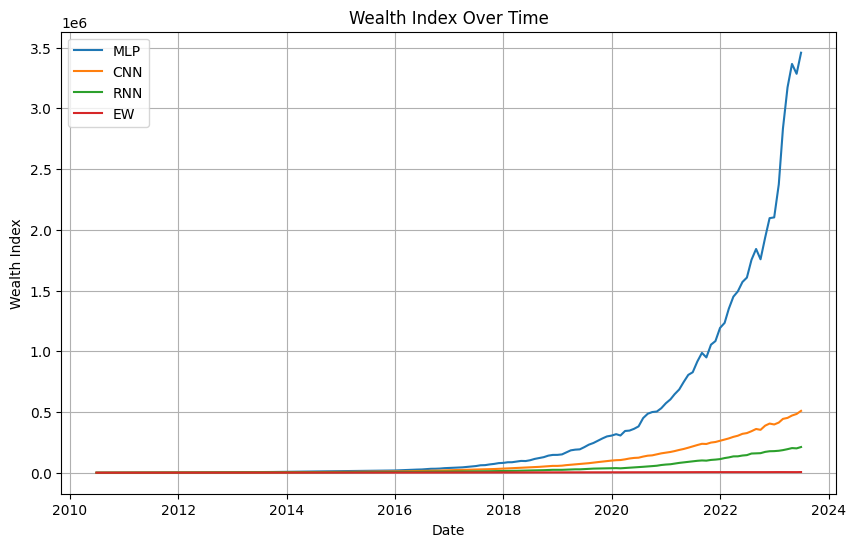

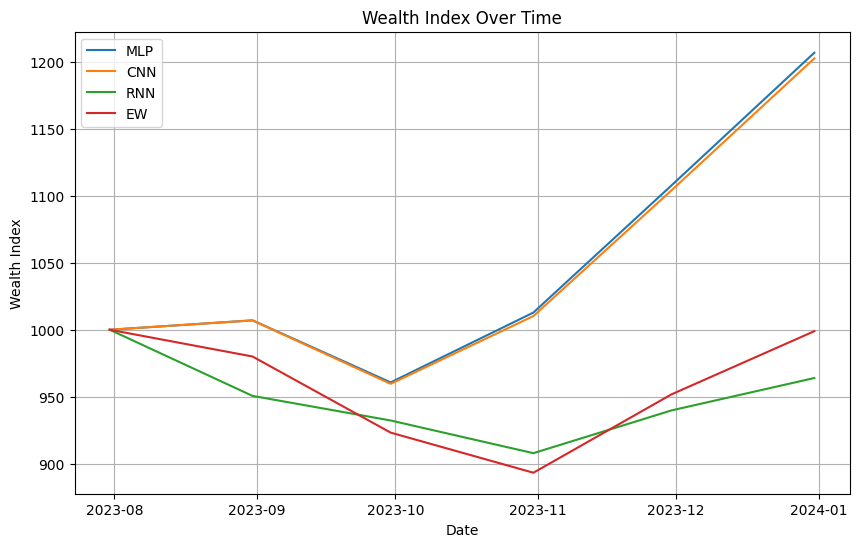

In [ ]:
train_metrics = pd.DataFrame()
test_metrics = pd.DataFrame()
train_rets = pd.DataFrame()
test_rets = pd.DataFrame()

for model_type in ['MLP', 'CNN', 'RNN']:
    print(f'Training: {model_type}...')

    if model_type == 'MLP':
        input_shape = df_trainval.iloc[:, :-asset_num].shape[1]
        input_shape = (input_shape,)
    elif model_type == 'CNN' or model_type == 'RNN':
        # need to reshape for CNNs and RNNs
        X_train_full = df_trainval.iloc[:, :-asset_num]
        X_train_reshaped = np.reshape(X_train_full.to_numpy(), (X_train_full.shape[0], X_train_full.shape[1], 1))
        input_shape = X_train_reshaped.shape[1:]

    param_grid = param_grids[f'{model_type.lower()}_param_grid']

    # instantiate the portfolio object
    portfolio = PortfolioModelTrainer(model_type=model_type,
                                      asset_num=asset_num,
                                      input_shape=input_shape,
                                      param_grid=param_grid,
                                      timestamp=timestamp)

    # perform grid_search on the dataset
    batch = df_trainval.shape[0]
    portfolio.grid_search(n_train, n_val, df_trainval, batch)

    print(f'Found best params for {model_type}!')
    with open(f"/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/preds/{timestamp}/{portfolio.model_type}/param_mapping.txt", "a") as f:
        f.write(f'The best params for {portfolio.model_type} were: {str(portfolio.best_params)}\n')

    print(f'Training optimal model for {model_type}...')

    # train optimal
    portfolio.train_optimal(df_trainval, batch)

    for model_version in ['train', 'test']:
        if model_version == 'train':
            df = df_trainval
            date_index = trainval_date_index
            prices = train_prices
        elif model_version == 'test':
            df = df_test
            date_index = test_date_index
            prices = test_prices
        pred_wts = portfolio.evaluate(df, date_index, ticker_list)
        metrics, rets = portfolio.perform_backtest(prices, initial_amount, timestamp, model_version)

        if model_version == 'train':
            train_metrics = pd.concat([train_metrics, metrics], axis=1)
            train_rets = pd.concat([train_rets, rets], axis=1)
        elif model_version == 'test':
            test_metrics = pd.concat([test_metrics, metrics], axis=1)
            test_rets = pd.concat([test_rets, rets], axis=1)

        portfolio.save_model(timestamp, model_version)


    print(f'Done training {model_type}!!!\n\n\n')


# let's capture performance for both train and test samples
for model_version in ['train', 'test']:
    if model_version == 'train':
        date_index = trainval_date_index
        prices = train_prices
        metrics = train_metrics
        rets = train_rets
    elif model_version == 'test':
        date_index = test_date_index
        prices = test_prices
        metrics = test_metrics
        rets = test_rets

    # get benchmark equal-weighted portfolio performance
    ew_portfolio = PortfolioModelTrainer(model_type='EW',
                                        asset_num=asset_num,
                                        input_shape=None,
                                        param_grid=None,
                                        timestamp=timestamp)
    # ew train performance
    ew_portfolio.build_benchmark(date_index, ticker_list)
    ew_metrics, ew_rets = ew_portfolio.perform_backtest(prices, initial_amount, timestamp, model_version)

    metrics = pd.concat([metrics, ew_metrics], axis=1)
    rets = pd.concat([rets, ew_rets], axis=1)

    # save metrics and returns to disk
    metrics.to_csv(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/{timestamp}/{model_version}_metrics.csv')
    rets.to_csv(f'/content/drive/My Drive/CapstoneProject/CapstoneModularity/WQU_5457/data/model_data/{timestamp}/{model_version}_rets.csv')

    # plot and save wealth index
    plot_wealth_index(rets, initial_amount, timestamp, 'NN_' + model_version)